# Plotting PyPSA results

### Jupyter scripts need to be improved


In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  C:\Users\Lenovo\Desktop\pypsa-africa
Had to go 0 folder(s) up.


In [2]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [38]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_15_ec_lcopt_Co2L-3H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_15_ec_lcopt_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [26]:
n = n_solve

In [39]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones)

n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,2.264879e-10,primary_energy,NaN,co2_emissions


In [123]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

n.objective / n.loads_t.p.sum().sum()

64.18743473604145

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x1ecc56c0d60>,
 <matplotlib.collections.LineCollection at 0x1ecc4bb7880>)

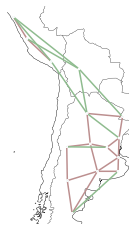

In [41]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

n.plot()

In [42]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps

len(n.snapshots)

2920

### Overview components

In [37]:
#Imprimir la lista de componentes considerados en el dataframe creado (

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 45 entries
Component 'Carrier' has 14 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 18 entries
Component 'LineType' has 32 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 69 entries
Component 'Load' has 15 entries
Component 'Generator' has 90 entries
Component 'StorageUnit' has 10 entries
Component 'Store' has 30 entries


### Energy balance

In [124]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
#https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
AR 0 H2          0.000000e+00
AR 1 H2          0.000000e+00
AR 10 H2         0.000000e+00
AR 2 H2          0.000000e+00
AR 3 H2          0.000000e+00
AR 4 H2         -1.387779e-17
AR 5 H2          0.000000e+00
AR 6 H2          6.938894e-18
AR 7 H2          1.387779e-17
AR 8 H2          0.000000e+00
AR 9 H2          6.938894e-18
BO 0 H2          6.661338e-16
PE 0 H2         -4.163336e-17
PE 1 H2          2.081668e-17
PE 2 H2          2.775558e-17
AR 0 battery     3.469447e-18
AR 1 battery    -7.546047e-17
AR 10 battery   -5.204170e-18
AR 2 battery     1.101549e-16
AR 3 battery    -1.431147e-17
AR 4 battery     3.295975e-17
AR 5 battery     6.071532e-18
AR 6 battery     1.474515e-17
AR 7 battery     6.938894e-18
AR 8 battery     5.204170e-17
AR 9 battery     2.168404e-17
BO 0 battery     9.020562e-17
PE 0 battery    -3.469447e-17
PE 1 battery     3.469447e-17
PE 2 battery    -8.326673e-17
dtype: float64

In [72]:
# se imprimen todos los generadores considerados en el modelo

n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators.head()

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'marginal_cost',
       'p_nom_extendable', 'bus', 'carrier', 'efficiency', 'control',
       'p_nom_opt', 'sign', 'build_year', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'type', 'p_nom_min', 'p_min_pu',
       'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,marginal_cost,p_nom_extendable,bus,carrier,efficiency,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AR 0 CCGT,NaN,0.000000,2038.340000,0.000000,47.210073,False,AR 0,CCGT,0.500,Slack,2038.340000,1.0,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 coal,inf,0.000000,644.000000,0.000000,24.114256,False,AR 0,coal,0.464,,644.000000,1.0,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 oil,NaN,0.000000,3070.072767,0.000000,130.237175,False,AR 0,oil,0.393,,3070.072767,1.0,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 onwind,3.586824e+05,83039.074064,0.000000,109295.569252,0.024483,True,AR 0,onwind,1.000,,0.012756,1.0,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
AR 0 solar,2.436947e+05,39419.953532,0.000000,55064.071419,0.020259,True,AR 0,solar,1.000,,0.446897,1.0,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [129]:
#Imprimir solo los generadores de Bolivia

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,marginal_cost,p_nom_extendable,bus,carrier,efficiency,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 onwind,1.560036e+06,160134.406942,0.000000e+00,109295.569252,0.024652,True,BO 0,onwind,1.0,Slack,6.341231e-03,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,6.614645e+05,122030.627970,0.000000e+00,55064.071419,0.019461,True,BO 0,solar,1.0,,6.590103e+02,1.000,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 load,inf,NaN,1.000000e+09,0.000000,8000.010923,False,BO 0,load,1.0,PQ,1.000000e+09,0.001,0,0,0,1,0,,0.0,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [127]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Argentina

idx = ['AR' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()

11000030597.663305

In [44]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


-25378194.702467114

### Total installed generator capacity

In [62]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

,p_nom_max,weight,p_nom,capital_cost,marginal_cost,p_nom_extendable,efficiency,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_nom_min,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000e+00,1.046207e+04,0.000000e+00,613.730183,0,6.500,1.046207e+04,13.000,0,0,0,13,0,0.0,0.0,13.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,13.0,13.0
OCGT,inf,0.000000e+00,7.127537e+03,0.000000e+00,291.973658,0,1.950,7.127537e+03,5.000,0,0,0,5,0,0.0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
coal,NaN,0.000000e+00,2.359200e+03,0.000000e+00,120.568532,0,2.320,2.359200e+03,5.000,0,0,0,5,0,0.0,0.0,5.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,5.0,5.0
load,NaN,0.000000e+00,1.500000e+10,0.000000e+00,120000.151395,0,15.000,1.500000e+10,0.015,0,0,0,15,0,0.0,0.0,15.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,15.0,15.0
oil,inf,0.000000e+00,1.244730e+04,0.000000e+00,1562.842939,0,4.716,1.244730e+04,12.000,0,0,0,12,0,0.0,0.0,12.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,12.0,12.0
onwind,1.015664e+07,1.976444e+06,0.000000e+00,1.639434e+06,0.374017,15,15.000,1.092435e+04,15.000,0,0,0,15,0,0.0,0.0,15.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,15.0,15.0
ror,NaN,6.145570e+03,6.145570e+03,2.709407e+06,0.099659,0,9.000,6.145570e+03,10.000,0,0,0,10,0,0.0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
solar,5.027147e+06,8.764364e+05,0.000000e+00,8.259611e+05,0.297478,15,15.000,2.364245e+04,15.000,0,0,0,15,0,0.0,0.0,15.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,15.0,15.0


In [93]:
n.stores_t.p.head()

Store,AR 0 H2,AR 1 H2,AR 10 H2,AR 2 H2,AR 3 H2,AR 4 H2,AR 5 H2,AR 6 H2,AR 7 H2,AR 8 H2,AR 9 H2,BO 0 H2,PE 0 H2,PE 1 H2,PE 2 H2,AR 0 battery,AR 1 battery,AR 10 battery,AR 2 battery,AR 3 battery,AR 4 battery,AR 5 battery,AR 6 battery,AR 7 battery,AR 8 battery,AR 9 battery,BO 0 battery,PE 0 battery,PE 1 battery,PE 2 battery
snapshot,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-0.000098,-0.004461,-0.000074,0.000133,-0.000102,-0.000058,-0.000020,-0.004986,-0.003604,-0.000161,-0.004239,0.000825,0.001071,0.001082,0.001077,-0.000101,-0.008525,0.000214,-0.000233,-0.000149,-0.001103,-0.000158,-0.008269,-0.000395,-0.000465,-0.007279,0.010518,0.001694,0.001734,0.001675
2013-01-01 03:00:00,-0.000061,0.001435,-0.000029,0.000154,-0.000057,0.000363,0.000018,0.000346,0.003881,-0.000104,0.000506,-0.000832,0.001097,0.001108,0.001104,0.000177,0.002882,0.000241,0.000081,0.000241,0.000794,0.000140,0.002976,0.003184,0.000137,0.002618,-0.005713,0.002793,0.002823,0.002737
2013-01-01 06:00:00,-0.000051,0.001430,-0.000017,0.000159,-0.000047,0.000375,0.000037,0.000359,0.003773,-0.000085,0.000521,-0.000819,-0.000193,-0.000179,-0.000187,0.000181,0.001063,0.000254,0.000126,0.000240,0.000652,0.000246,0.000973,0.001138,0.000173,0.000852,-0.002832,-0.005166,-0.005168,-0.005220
2013-01-01 09:00:00,-0.000068,0.001409,-0.000039,0.000147,-0.000057,0.000318,0.000030,0.000348,0.003682,-0.000061,0.000520,-0.000852,0.001086,0.001107,0.001107,0.000082,0.000714,0.000251,-0.000037,0.000335,0.000691,0.000336,0.000595,0.000819,0.000391,0.000553,-0.002150,0.006414,0.006517,0.006426
2013-01-01 12:00:00,-0.000085,0.001324,-0.000082,0.000138,-0.000119,0.000264,0.000009,0.000286,0.003460,-0.000124,0.000469,-0.000844,-0.000281,-0.000271,-0.000260,-0.000319,0.000626,-0.000132,0.000240,-0.000081,0.002043,0.000614,0.000018,0.000536,-0.000306,0.000195,-0.001138,0.001508,0.001502,0.001590


<AxesSubplot:xlabel='snapshot'>

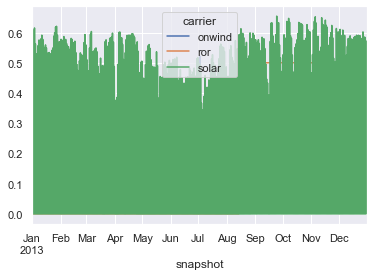

In [14]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [15]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [94]:
n.loads_t.p.sum().sum()

93050599.29425742

In [95]:
n.generators_t.p.sum().sum()

67672404.5917903

In [18]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
AR 0  CCGT         0.000148
      OCGT         0.000585
      load       300.000000
      oil          0.000075
      onwind       0.000000
                    ...    
PE 1  load       300.000000
      oil          0.000101
      onwind       0.000000
      ror          0.000134
      solar        0.000000
Name: p_nom, Length: 63, dtype: float64

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

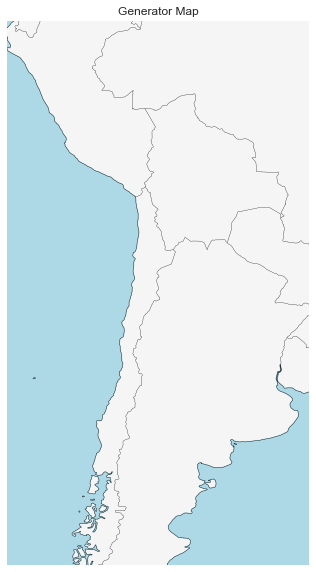

In [97]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [125]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
AR 0     1.000006e+09
AR 1     1.000002e+09
AR 10    1.000011e+09
AR 2     1.000011e+09
AR 3     1.000001e+09
AR 4     1.000007e+09
AR 5     1.000004e+09
AR 6     1.000003e+09
AR 7     1.000004e+09
AR 8     1.000000e+09
AR 9     1.000008e+09
BO 0     1.000001e+09
PE 0     1.000006e+09
PE 1     1.000000e+09
PE 2     1.000009e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

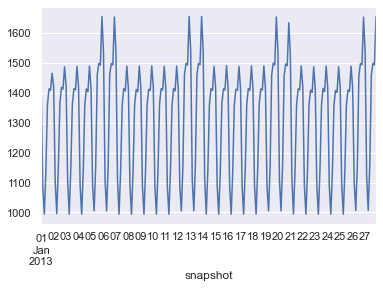

In [21]:
n.loads_t.p_set.loc["2013-01-01":"2013-01-27","BO 0"].plot()

In [22]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [23]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
AR 0    3.516827e+06
AR 1    1.133223e+07
AR 2    2.188431e+07
AR 3    1.137545e+07
AR 4    6.449651e+06
AR 5    6.788410e+06
AR 6    5.754304e+06
BO 0    3.779364e+06
PE 0    1.571429e+07
PE 1    6.455749e+06
Name: load, dtype: float64

In [24]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
AR 0    3.516827e+06
AR 1    1.133223e+07
AR 2    2.188431e+07
AR 3    1.137545e+07
AR 4    6.449651e+06
AR 5    6.788410e+06
AR 6    5.754304e+06
BO 0    3.779364e+06
PE 0    1.571429e+07
PE 1    6.455749e+06
Name: load, dtype: float64

In [115]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
AR 0     1.000006e+09
AR 1     1.000002e+09
AR 10    1.000011e+09
AR 2     1.000011e+09
AR 3     1.000001e+09
AR 4     1.000007e+09
AR 5     1.000004e+09
AR 6     1.000003e+09
AR 7     1.000004e+09
AR 8     1.000000e+09
AR 9     1.000008e+09
BO 0     1.000001e+09
PE 0     1.000006e+09
PE 1     1.000000e+09
PE 2     1.000009e+09
Name: p_nom_opt, dtype: float64

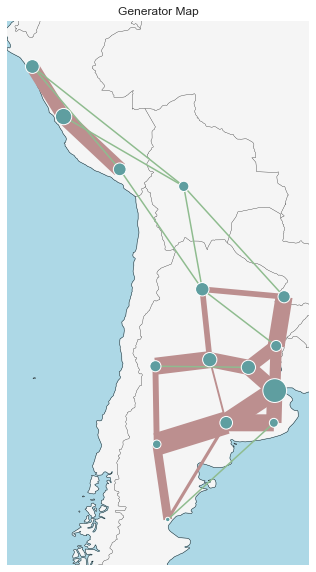

In [104]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [105]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
AR 0  CCGT       2.038340e+03
      coal       6.440000e+02
      load       1.000000e+09
      oil        3.070073e+03
      onwind     1.275619e-02
                     ...     
AR 9  AC load    5.738136e+06
BO 0  AC load    3.779364e+06
PE 0  AC load    9.527409e+06
PE 1  AC load    6.814538e+06
PE 2  AC load    5.828096e+06
Length: 105, dtype: float64

### Plot of Average Marginal Price

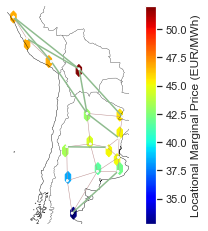

In [106]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

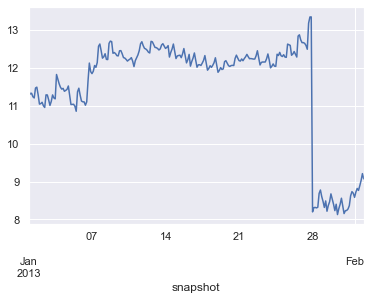

In [107]:
n.stores_t.e.loc["2013-01-01":"2013-02-01"].sum(axis=1).plot()

In [108]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
DC                    1637.965808
H2 electrolysis          0.143554
H2 fuel cell             1.780675
battery charger          0.231524
battery discharger       0.257249
Name: p_nom_opt, dtype: float64